# Fit Model Parameters to Data #
### Nitika Yadlapalli ###
Use existing all sky maps published on LAMBDA (https://lambda.gsfc.nasa.gov/) to find model parameters that best fit the data

Currently, MCMC models based on example shown here: https://emcee.readthedocs.io/en/v2.2.1/user/line/

In [525]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import emcee
from scipy import stats
import corner

import ModelDefinitions as MD
import LogProb as LP
import importlib
importlib.reload(LP)

<module 'LogProb' from '/home/nitikayad96/Research/Radio_Background/radio-background/LogProb.py'>

In [4]:
# relevant constants

c = 3e10
k = 1.381e-16
pc = 3.086e18
d = 8e3*pc # distance from galactic center to sun ~8kpc

Jy = 1e-23 # erg s^-1 cm^-2 Hz^-1

In [5]:
# function describing line of sight through disk and halo models, based on sky coordinates, 
# geometry of disk/halo
# l and b given in degrees (as from hp.pix2ang) - convert to radians
# d = distance of sun from center of galaxy

def LineOfSightDisk(l, b, d, R_disk, h_disk):
    
    # first calculate length of line of sight through disk
    
    l = np.array(l)
    b = np.array(b)
    
    l = np.deg2rad(l)
    b = np.deg2rad(b)

    l = np.array([np.min([l_, (2*np.pi)-l_]) for l_ in l])
    b = np.abs(b)
    B_disk =  -l - np.arcsin((d/R_disk)*np.sin(l)) + np.pi
    r_disk = np.sqrt(-(2*R_disk*d*np.cos(B_disk)) + (R_disk**2) + (d**2))
    
    b_crit = np.arctan(0.5*h_disk/r_disk)
    b_below = np.nan_to_num((b <= b_crit)*r_disk/(np.cos(b)))
    b_above = np.nan_to_num((b > b_crit)*0.5*h_disk/(np.sin(b)))
    
    D_disk = b_below+b_above
        
    return np.array(D_disk)
        

def LineOfSightHalo(l, b, d, R_halo):  
    
    # calculate length of line of sight through halo
    
    l = np.deg2rad(np.array(l))
    b = np.deg2rad(np.array(b))
    
    l = np.minimum(l, (2*np.pi)-l)
    
    b = np.abs(b)
    b_ = np.pi - b
    
    d_proj = d*np.abs(np.cos(l))
    B_halo1 = np.pi - l - np.arcsin((d/R_halo)*np.sin(l))
    
    R_eff_above = np.sqrt((R_halo**2) + (d**2) - (2*R_halo*d*np.cos(B_halo1))) + d_proj
    B_halo_above = (np.pi - b_ - np.arcsin((d_proj/R_eff_above)*np.sin(b)))
    D_tot_above = (l >= np.pi/2)*(np.sqrt((R_eff_above**2) + (d_proj**2) - (2*R_eff_above*d_proj*np.cos(B_halo_above))))
        
    R_eff_below = np.sqrt((R_halo**2) + (d**2) - (2*R_halo*d*np.cos(B_halo1))) - d_proj
    B_halo_below = (np.pi - b - np.arcsin((d_proj/R_eff_below)*np.sin(b)))
    D_tot_below = (l < np.pi/2)*(np.sqrt((R_eff_below**2) + (d_proj**2) - (2*R_eff_below*d_proj*np.cos(B_halo_below))))
    
    
    D_halo = D_tot_above + D_tot_below
    
    return D_halo

In [27]:
# Construct a T_b vs csc(b) graph

def cscbplot(Tmap, NSIDE):

    b_range = np.linspace(10,90,15)

    cscb = []
    Tb_mean = []

    for i in range(len(b_range)-1):

        b1 = 90 - b_range[i]
        b2 = 90 - b_range[i+1]

        bmid = 0.5*(b_range[i] + b_range[1+i])

        cscb.append(1/(np.sin(np.deg2rad(bmid)))) 

        idx = hp.query_strip(NSIDE, np.deg2rad(b2), np.deg2rad(b1))
        Tb_mean.append(np.mean(Tmap[idx]))
        
    return [cscb, Tb_mean]
    

In [8]:
## Set up known parameters ##

NSIDE_sky = 256

NSIDE_dg = 32
NPIX_dg = hp.nside2npix(NSIDE_dg)

m = np.arange(NPIX_dg)
coords = hp.pix2ang(NSIDE_dg, m, lonlat=True)
l = coords[0]
b = coords[1]

nu = 1420e6
T_eg = 0.08866 # K
T_rms = (50/3)*1e-3 # K
T_CMB = 2.725 # K

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


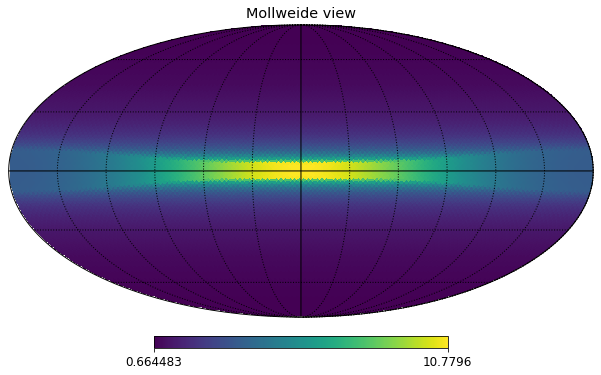

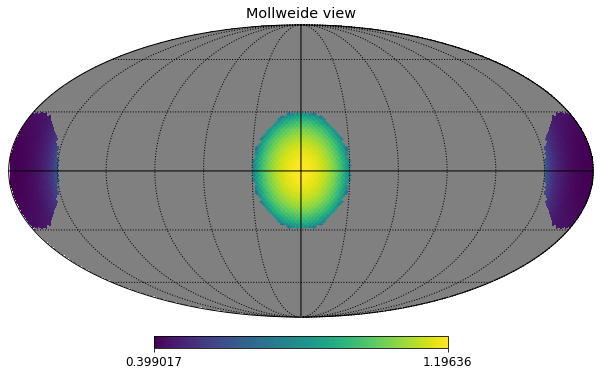

In [476]:
# test  models

test_disk = LineOfSightDisk(l, b, d, 2*d, 0.37*d)*9e-41*(c**2)/(2*k*(nu**2))
hp.mollview(test_disk)
hp.graticule()

test_halo = LineOfSightHalo(l, b, d, 0.5*d)*2e-41*(c**2)/(2*k*(nu**2))
hp.mollview(test_halo)
hp.graticule()

NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/home/nitikayad96/.local/lib/python3.6/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/nitikayad96/.local/lib/python3.6/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/nitikayad96/.local/lib/python3.6/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/nitikayad96/.local/lib/python3.6/site-packages/healpy/projaxes.py:1176: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/home/nitikayad96/.local/lib/python3.6/site-packages/healpy/projaxes.py:1177: RuntimeWarning: invalid value encountered

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


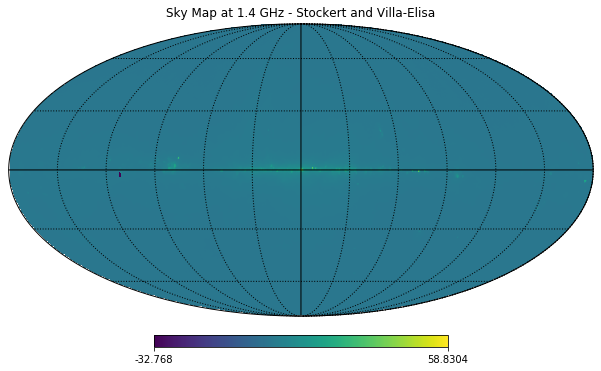

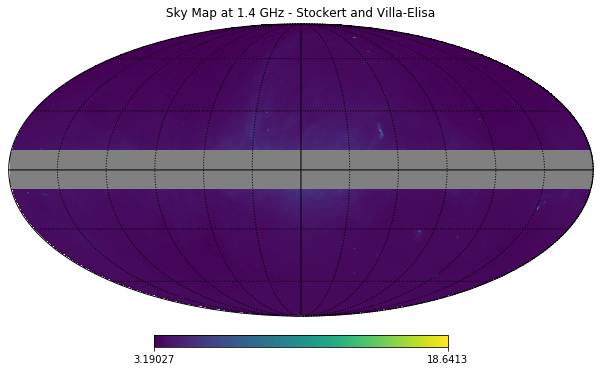

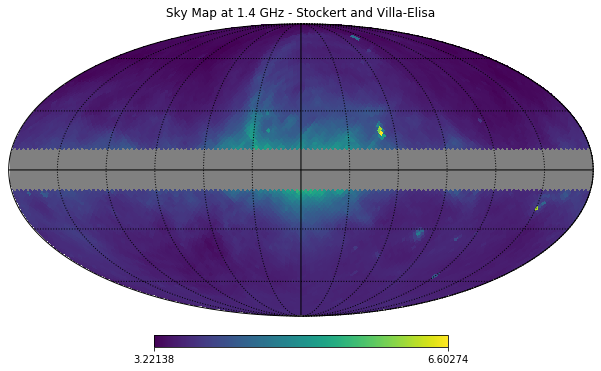

In [10]:
## show 1.4 GHz sky map ##

map_1420 = hp.read_map('STOCKERT+VILLA-ELISA_1420MHz_1_256.fits')
map_1420_mod = hp.read_map('STOCKERT+VILLA-ELISA_1420MHz_1_256.fits')
map_1420_dg = hp.pixelfunc.ud_grade(map_1420, 32)

#Mask all pixels between -10 < b < +10 by setting them all to zero
idx = hp.query_strip(NSIDE_sky, np.deg2rad(90-10), np.deg2rad(90+10))
map_1420_mod[idx] = None
#map_1420_dg[idx] = None

idx_dg = hp.query_strip(NSIDE_dg, np.deg2rad(90-10), np.deg2rad(90+10))
map_1420_dg[idx_dg] = None

hp.mollview(map_1420/1000, title = "Sky Map at 1.4 GHz - Stockert and Villa-Elisa")
hp.graticule()

hp.mollview(map_1420_mod/1000, title = "Sky Map at 1.4 GHz - Stockert and Villa-Elisa")
hp.graticule()

hp.mollview(map_1420_dg/1000, title = "Sky Map at 1.4 GHz - Stockert and Villa-Elisa")
hp.graticule()

## 1.4 GHz Map with Disk and Extragalactic Only Model ##
Sky map used: https://lambda.gsfc.nasa.gov/product/foreground/fg_stockert_villa_info.cfm

Assume only disk (no halo), and use uniform extragalactic sky brightness as calculated in sky-brightness-model notebook

## 1.4 GHz Map with Disk+Halo and Extragalactic Model ##
Sky map used: https://lambda.gsfc.nasa.gov/product/foreground/fg_stockert_villa_info.cfm

Assume only disk+halo, and use uniform extragalactic sky brightness as calculated in sky-brightness-model notebook

In [147]:
# def log of likelihood function

def lnlike(param, nu, l, b, T_sky, T_eg, idx_exb):
    
    #idx_exb = latitudes of -10 < b < 10 that we wish to exclude
    
    R_disk = param[0]
    h_disk = param[1]
    j_disk = param[2]
    R_halo = param[3]
    j_halo = param[4]
    
    # residuals = T_res = T_sky - T_eg - T_disk - T_halo
    T_notdisk = T_sky/1000 - T_eg - T_CMB
    residuals = T_notdisk - (LineOfSightDisk(l, b, d, R_disk, h_disk)*j_disk + LineOfSightHalo(l, b, d, R_halo)*j_halo)*(c**2)/(2*k*(nu**2))
    residuals[idx_exb] = None
    
    neg_res_idx = np.argwhere(residuals<=0)
    neg_res = residuals[neg_res_idx]
    
    if len(neg_res)==0:
        return -np.inf
    
    neg_res2 = np.concatenate((neg_res, np.negative(neg_res)))
    L = stats.kstest(neg_res2.T, 'norm')[1]

    lnL = np.log(L)
    return lnL

# set up log priors

def lnprior(param):
    
    R_disk = param[0]
    h_disk = param[1]
    j_disk = param[2]
    R_halo = param[3]
    j_halo = param[4]
    
    if d < R_disk < 100*d and 0 < h_disk < 5*d and 1e-42 < j_disk < 1e-39 and R_halo > 0 and 1e-43 < j_halo < 1e-38 :
        return 0.0
    
    return -np.inf


# full log probability 

def lnprob(param, nu, l, b, T_sky, T_eg, idx_exb):
    lp = lnprior(param)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(param, nu, l, b, T_sky, T_eg, idx_exb)

In [148]:
# Use this cell to test good starting point for walkers
idx_exb = hp.query_strip(NSIDE_dg, np.deg2rad(90-10), np.deg2rad(90+10))

testln = lnlike([2*d, 0.17*d, 2e-41, 4*d, 2.2e-42], nu, l, b, map_1420_dg, T_eg, idx_exb)
print(testln)
print(np.exp(testln))

-0.037691163331336396
0.963010307865293


/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal


In [149]:
# initialize walkers

ndim = 5
nwalkers = 200
param_init = [2*d, 0.17*d, 2e-41, 4*d, 2.2e-42]

init = [param_init]
for i in range(nwalkers-1):
    #start walkers such that all values are positive and mean multiplicative factor is 1
    vary = np.abs(np.random.randn(ndim)+1)
    init.append([param_init[i]*vary[i] for i in range(ndim)])
    
init = np.array(init)

In [150]:
#set up sampler and run MCMC

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(nu, l, b, map_1420_dg, T_eg, idx_exb))

SAMPLER = sampler.run_mcmc(init, 1000)

/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal
/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


In [128]:
samples_ = np.array(sampler.chain)

np.savez("disk+halo+eg+cmb.npz", samples=samples_ )

In [229]:
samples = np.load("disk+halo+eg+cmb.npz")['samples']

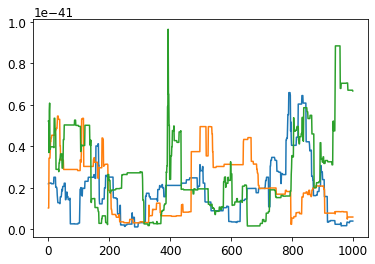

In [230]:
plt.plot(samples[0,:,4])
plt.plot(samples[1,:,4])
plt.plot(samples[2,:,4])


In [231]:
ndim=5
samples_reshape = samples.reshape((-1, ndim))
samples_corner = np.log10(samples_reshape)

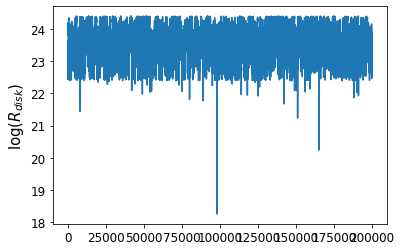

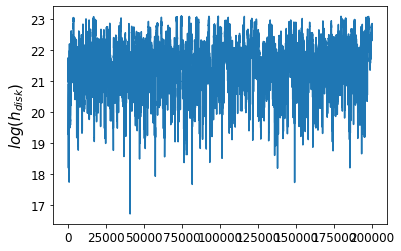

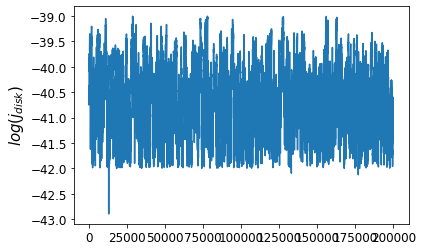

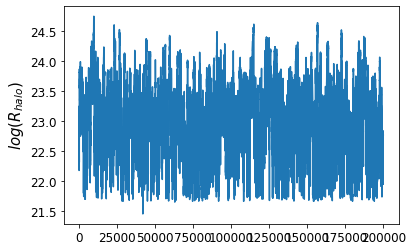

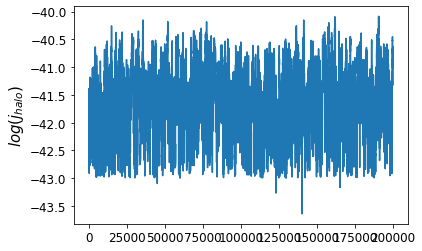

In [232]:
labels=["log($R_{disk})$", "$log(h_{disk})$", "$log(j_{disk})$" ,"$log(R_{halo})$","$log(j_{halo})$"]
for i in range(ndim):
    plt.figure(i)
    plt.plot(samples_corner[:,i])
    plt.ylabel(labels[i], fontsize='15')

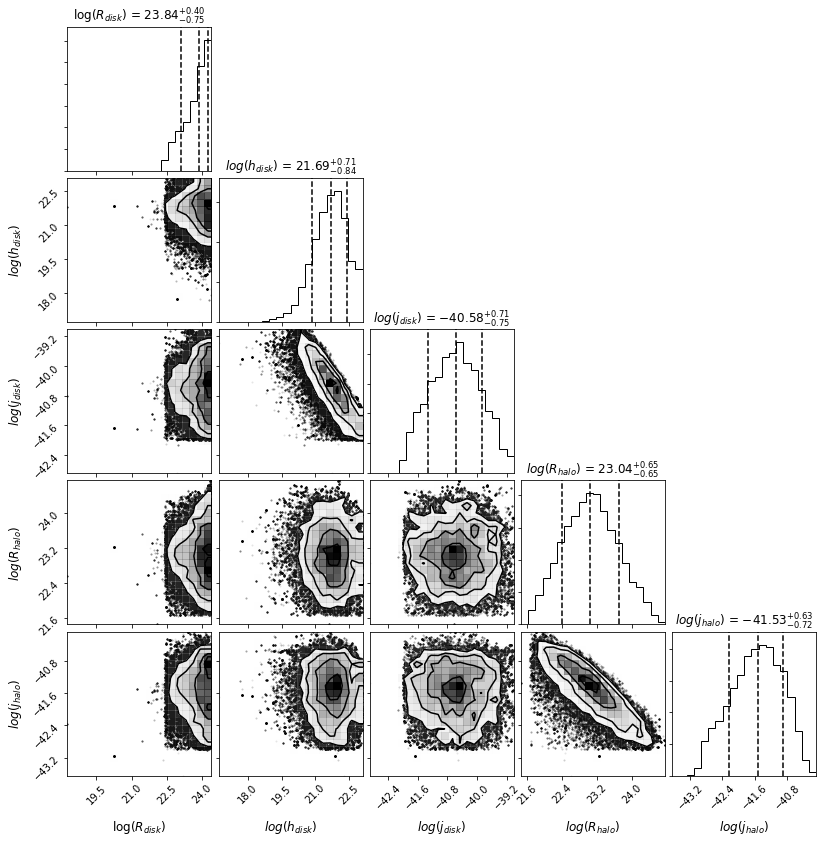

In [64]:
fig = corner.corner(samples_corner, labels=["log($R_{disk})$", "$log(h_{disk})$", "$log(j_{disk})$" ,"$log(R_{halo})$","$log(j_{halo})$"],
                    label_kwargs={"fontsize": 12}, show_titles=True, title_kwargs={"fontsize": 12},
                    quantiles=[0.16,0.5,0.84])

plt.savefig("notes/corner_disk+halo_kstest.jpg")

/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less_equal
  


0.0


(array([1.170e+02, 2.458e+03, 4.501e+03, 1.928e+03, 4.970e+02, 2.610e+02,
        1.750e+02, 8.900e+01, 5.200e+01, 1.700e+01, 1.300e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00]),
 array([-0.35003048, -0.18909966, -0.02816883,  0.132762  ,  0.29369282,
         0.45462365,  0.61555447,  0.7764853 ,  0.93741613,  1.09834695,
         1.25927778,  1.42020861,  1.58113943,  1.74207026,  1.90300109,
         2.06393191,  2.22486274,  2.38579356,  2.54672439,  2.70765522,
         2.86858604]),
 <a list of 20 Patch objects>)

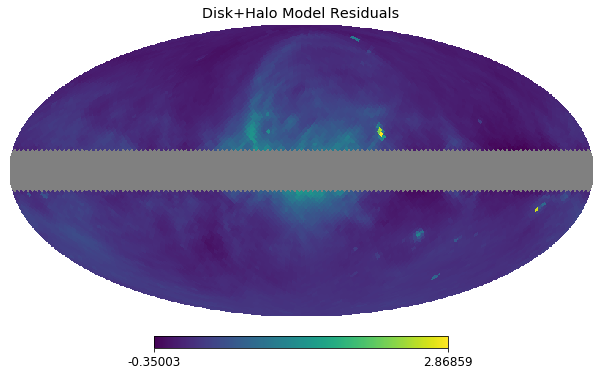

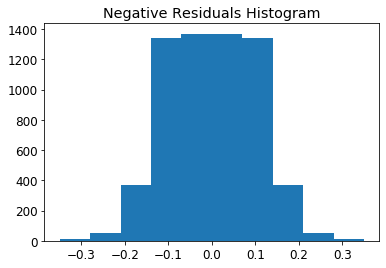

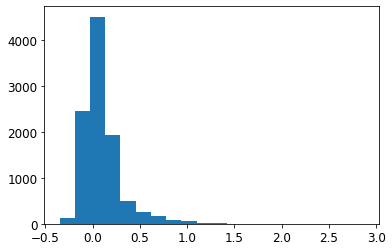

In [283]:
# plot residuals

R_disk = 10**np.percentile(samples_corner[:,0], 50)
h_disk = 10**np.percentile(samples_corner[:,1], 50)
j_disk = 10**np.percentile(samples_corner[:,2], 50)
R_halo = 10**np.percentile(samples_corner[:,3], 50)
j_halo = 10**np.percentile(samples_corner[:,4], 50)


T_notdisk = map_1420_dg/1000 - T_eg - T_CMB
residuals = T_notdisk - (LineOfSightDisk(l, b, d, R_disk, h_disk)*j_disk + LineOfSightHalo(l, b, d, R_halo)*j_halo)*(c**2)/(2*k*(nu**2))
residuals[idx_exb] = None

neg_res_idx = np.argwhere(residuals<=0)
neg_res = residuals[neg_res_idx]
neg_res2 = np.concatenate((neg_res, -1*neg_res))

hp.mollview(residuals, title="Disk+Halo Model Residuals")
plt.savefig("notes/res_disk+halomcmc.jpg")

plt.figure()
plt.hist(neg_res2, 10)
plt.title('Negative Residuals Histogram')

print(stats.kstest(neg_res2, 'norm')[1])

plt.figure()
plt.hist(residuals, bins=20)


In [131]:
# Mean acceptance fraction

avg_acc = np.mean(sampler.acceptance_fraction)

print(avg_acc)



0.176815


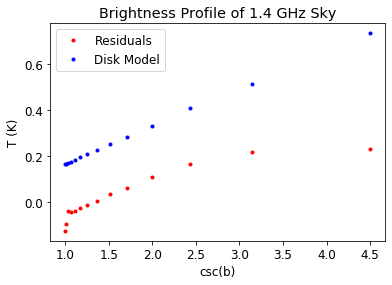

In [122]:
# Construct a T_b vs csc(b) graph

b_range = np.linspace(10,90,15)

cscb = []

Tb_disk = []
#Tb_sky = []
Tb_res = []

for i in range(len(b_range)-1):
    
    b1 = 90 - b_range[i]
    b2 = 90 - b_range[i+1]
    
    bmid = 0.5*(b_range[i] + b_range[1+i])
    
    cscb.append(1/(np.sin(np.deg2rad(bmid)))) 
    
    idx = hp.query_strip(NSIDE_dg, np.deg2rad(b2), np.deg2rad(b1))
    Tb_disk.append(np.mean(disk_model[idx]))
    #Tb_sky.append(np.mean(sky[idx]))
    Tb_res.append(np.mean(residuals[idx]))
    
plt.figure(0)
plt.rcParams.update({'font.size': 12})
plt.title('Brightness Profile of 1.4 GHz Sky')
plt.ylabel('T (K)')
plt.xlabel('csc(b)')
plt.plot(cscb, Tb_res, 'r.', label='Residuals')
plt.plot(cscb, Tb_disk, 'b.', label='Disk Model')
plt.legend()
plt.savefig('notes/1420_cscb_compare.jpg')

## 1.4 GHz Map with Disk+Halo+Uniform Background and Extragalactic+CMB Model ##
Sky map used: https://lambda.gsfc.nasa.gov/product/foreground/fg_stockert_villa_info.cfm

Assume only disk (no halo), and use uniform extragalactic sky brightness as calculated in sky-brightness-model notebook

In [49]:
# Use this cell to test good starting point for walkers
idx_exb = hp.query_strip(NSIDE_dg, np.deg2rad(90-10), np.deg2rad(90+10))

testln = LP.diskhalobkg([2*d, 0.17*d, 2e-41, 4*d, 2.2e-42, 0.1], nu, l, b, map_1420_dg/1000, T_eg, idx_exb)
print(testln)
print(np.exp(testln))

-0.07116040341052847
0.9313124944455867


In [368]:
samples = np.load("disk+halo+bkg+eg+cmb.npz")['samples']

ndim=6
samples_reshape = samples.reshape((-1, ndim))

samples_reshape[:,0] = np.log10(samples_reshape[:,0])
samples_reshape[:,1] = np.log10(samples_reshape[:,1])
samples_reshape[:,2] = np.log10(samples_reshape[:,2])
samples_reshape[:,3] = np.log10(samples_reshape[:,3])
samples_reshape[:,4] = np.log10(samples_reshape[:,4])

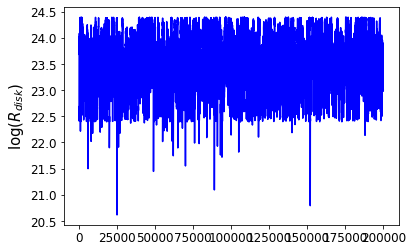

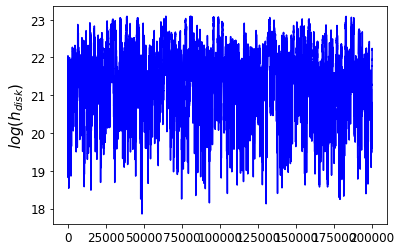

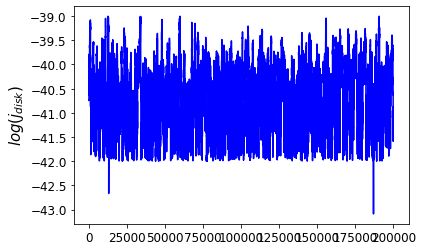

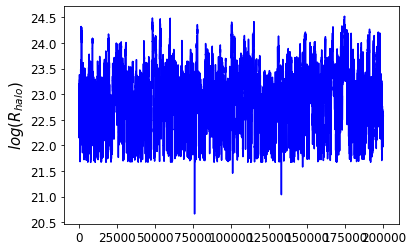

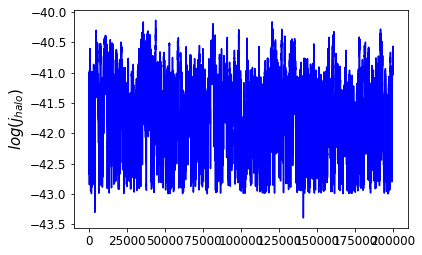

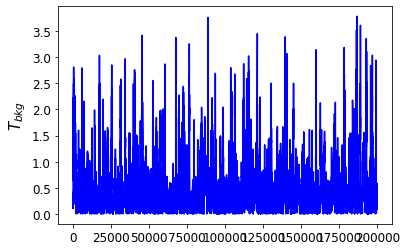

In [254]:
labels=["log($R_{disk})$", "$log(h_{disk})$", "$log(j_{disk})$" ,"$log(R_{halo})$","$log(j_{halo})$", "$T_{bkg}$"]
for i in range(ndim):
    plt.figure(i)
    plt.plot(samples_reshape[:,i],'b-')
    plt.ylabel(labels[i], fontsize='15')

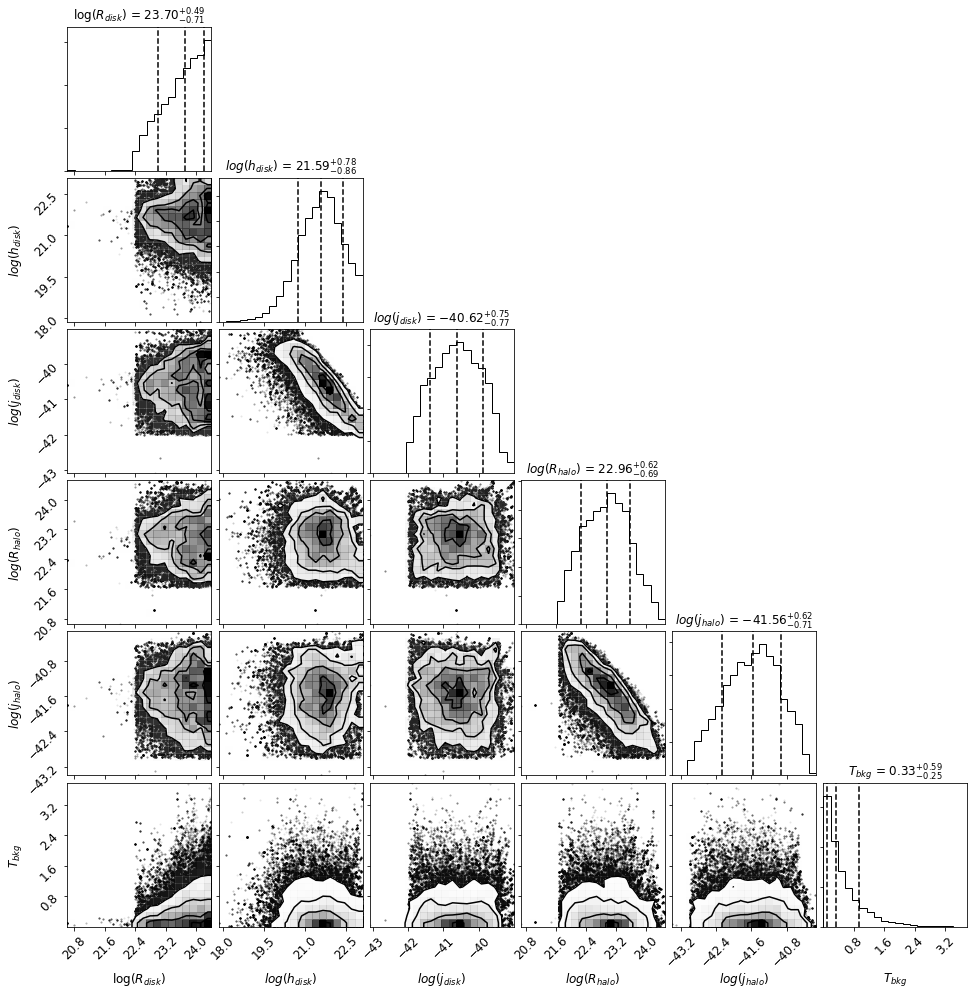

In [239]:
fig = corner.corner(samples_reshape, labels=["log($R_{disk})$", "$log(h_{disk})$", "$log(j_{disk})$" ,"$log(R_{halo})$","$log(j_{halo})$", "$T_{bkg}$"],
                    label_kwargs={"fontsize": 12}, show_titles=True, title_kwargs={"fontsize": 12},
                    quantiles=[0.16,0.5,0.84])

plt.savefig("notes/corner_disk+halo+bkg+eg+cmb_kstest.jpg")

5.025962376119376e-27
0.0


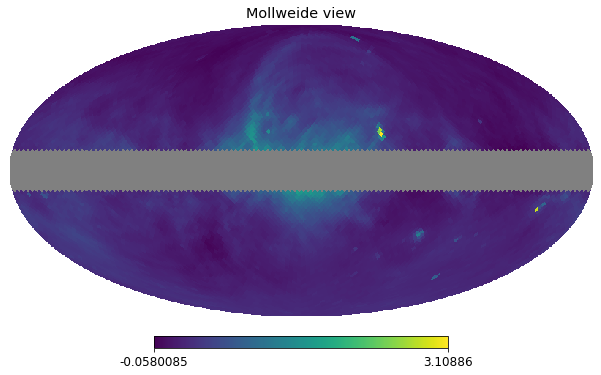

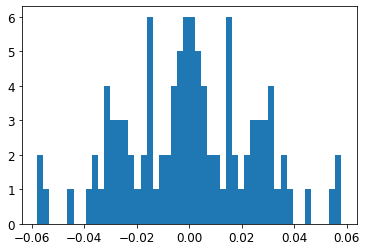

In [372]:
R_disk = 10**np.percentile(samples_reshape[:,0], 50)
h_disk = 10**np.percentile(samples_reshape[:,1], 50)
j_disk = 10**np.percentile(samples_reshape[:,2], 50)
R_halo = 10**np.percentile(samples_reshape[:,3], 50)
j_halo = 10**np.percentile(samples_reshape[:,4], 50)
T_bkg = -0.03#np.percentile(samples_reshape[:,5], 50)

residuals = (map_1420_dg/1000 - T_eg - T_CMB - T_bkg) - (LineOfSightDisk(l, b, d, R_disk, h_disk)*j_disk + LineOfSightHalo(l, b, d, R_halo)*j_halo)*(c**2)/(2*k*(nu**2))
hp.mollview(residuals)

notnan_idx = [i for i in range(len(residuals)) if np.isnan(residuals[i])==False]
residuals = residuals[notnan_idx]


neg_res = residuals[np.argwhere(residuals<=0)]
neg_res2 = np.concatenate((neg_res, -neg_res))

plt.figure()
plt.hist(neg_res2,bins=50)

print(stats.kstest(neg_res2, 'norm')[1])

## 1.4 GHz Map with Disk+Halo+Uniform Background Model
## NO Extragalactic+CMB ##
Sky map used: https://lambda.gsfc.nasa.gov/product/foreground/fg_stockert_villa_info.cfm

Assume disk and halo and a constant extragalactic background
Extragalactic contribution and CMB not included in this model

In [382]:
samples = np.load("disk+halo+bkg_ksD.npz")['samples']

ndim=6
samples_reshape = samples.reshape((-1, ndim))

samples_reshape[:,0] = np.log10(samples_reshape[:,0])
samples_reshape[:,1] = np.log10(samples_reshape[:,1])
samples_reshape[:,2] = np.log10(samples_reshape[:,2])
samples_reshape[:,3] = np.log10(samples_reshape[:,3])
samples_reshape[:,4] = np.log10(samples_reshape[:,4])

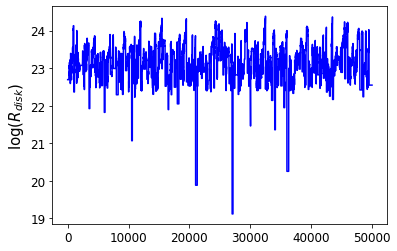

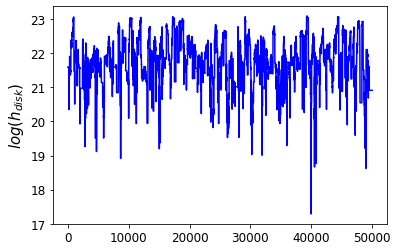

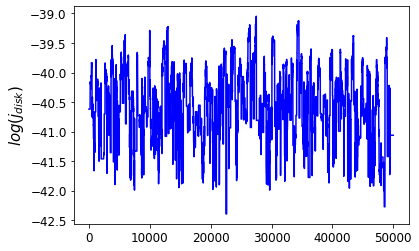

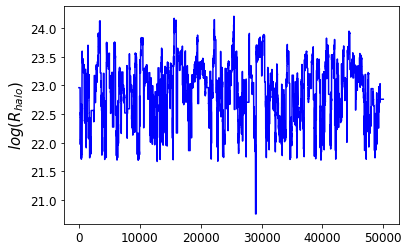

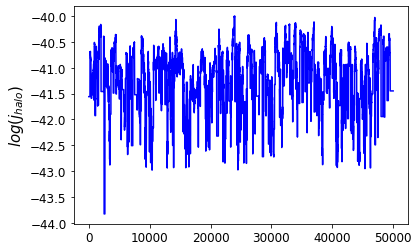

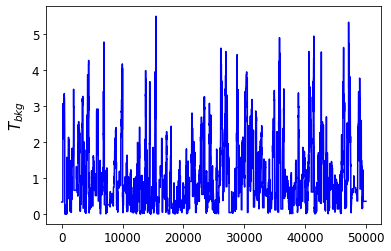

In [291]:
labels=["log($R_{disk})$", "$log(h_{disk})$", "$log(j_{disk})$" ,"$log(R_{halo})$","$log(j_{halo})$", "$T_{bkg}$"]
for i in range(ndim):
    plt.figure(i)
    plt.plot(samples_reshape[:,i],'b-')
    plt.ylabel(labels[i], fontsize='15')

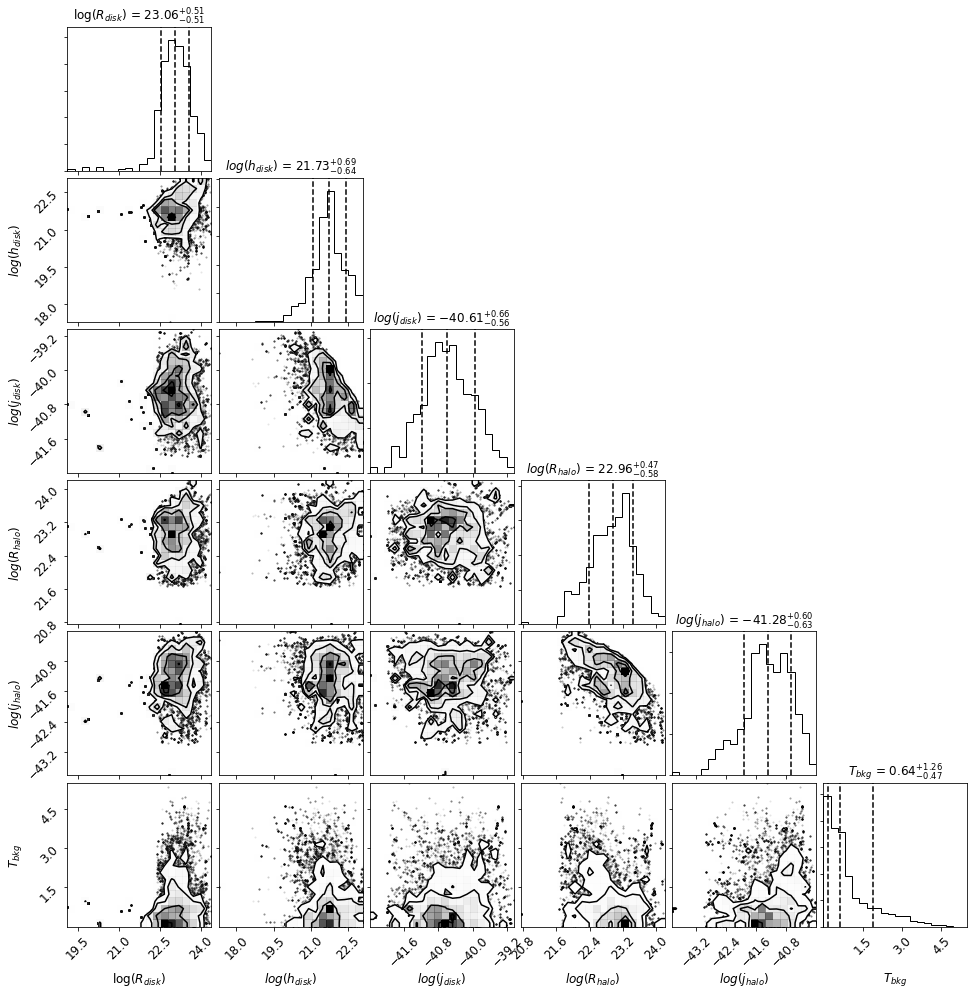

In [292]:
fig = corner.corner(samples_reshape, labels=["log($R_{disk})$", "$log(h_{disk})$", "$log(j_{disk})$" ,"$log(R_{halo})$","$log(j_{halo})$", "$T_{bkg}$"],
                    label_kwargs={"fontsize": 12}, show_titles=True, title_kwargs={"fontsize": 12},
                    quantiles=[0.16,0.5,0.84])

#plt.savefig("notes/corner_disk+halo+bkg_ksD.jpg")

5.209295346765322
2.103848086005414


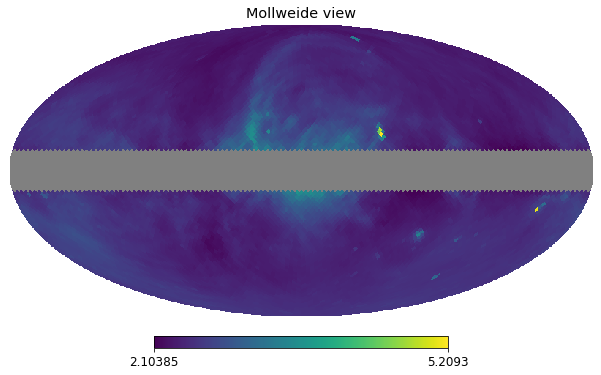

In [414]:
R_disk = 10**np.percentile(samples_reshape[:,0], 50.5)
h_disk = 10**np.percentile(samples_reshape[:,1], 50)
j_disk = 10**np.percentile(samples_reshape[:,2], 50)
R_halo = 10**np.percentile(samples_reshape[:,3], 50)
j_halo = 10**np.percentile(samples_reshape[:,4], 50)
T_bkg = np.percentile(samples_reshape[:,5], 16)

#R_disk, h_disk, j_disk, R_halo, j_halo, T_bkg = 2*d, 10**(21.59), 10**(-40.62), 10**(22.96), 10**(-41.56), 0.33

residuals = (map_1420_dg/1000 - T_bkg) - (LineOfSightDisk(l, b, d, R_disk, h_disk)*j_disk + LineOfSightHalo(l, b, d, R_halo)*j_halo)*(c**2)/(2*k*(nu**2))
hp.mollview(residuals)
residuals2 = [residuals[i] for i in range(len(residuals)) if i not in idx_exb]
#print(np.isnan(residuals2)==False)

for r in residuals2:
    if np.isnan(r)==True:
        print('There is a nan')

notnan_idx = [i for i in range(len(residuals)) if np.isnan(residuals[i])==False]
residuals3 = residuals[notnan_idx]

print(np.max(residuals2))
print(np.min(residuals2))
# res_hist = np.histogram(residuals, bins=100)
# hist_max = np.max(res_hist[1][np.argmax(res_hist[0])])
# neg_res = np.array([r for r in residuals if r<=hist_max])

# plt.figure()
# plt.hist(residuals, bins=100)

# neg_res2 = np.concatenate((neg_res, -neg_res+2*hist_max))
# #plt.figure()
# plt.hist(neg_res, color='r', bins=np.argmax(res_hist[0]))

# print(np.std(neg_res2))

-606972.9919665355
[2.54988617 2.50938008 2.51060176 ... 2.71543969 2.71900557 2.71233788]


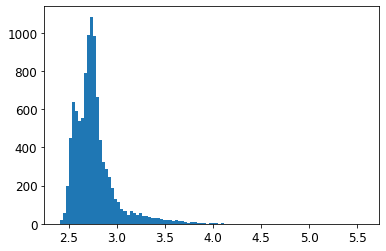

In [524]:
std_res = []

# p = 65
# # for p in np.linspace(0,100,10):
# R_disk = 10**np.percentile(samples_reshape[:,0], p)
# h_disk = 10**np.percentile(samples_reshape[:,1], p)
# j_disk = 10**np.percentile(samples_reshape[:,2], p)
# R_halo = 10**np.percentile(samples_reshape[:,3], p)
# j_halo = 10**np.percentile(samples_reshape[:,4], p)
# T_bkg = np.percentile(samples_reshape[:,5], 30)

R_disk, h_disk, j_disk, R_halo, j_halo, T_bkg = 2*d, 10**(21.59), 10**(-40.62), 10**(22.96), 10**(-41.56), 0.33

# hp.mollview(LineOfSightDisk(l, b, d, R_disk, h_disk))
# hp.mollview(LineOfSightHalo(l, b, d, R_halo))

# residuals = (map_1420_dg/1000 - T_bkg) - (LineOfSightDisk(l, b, d, R_disk, h_disk)*j_disk + LineOfSightHalo(l, b, d, R_halo)*j_halo)*(c**2)/(2*k*(nu**2))

# residuals2 = np.array([residuals[i] for i in range(len(residuals)) if np.isnan(residuals[i])==False])

# hp.mollview(residuals)

# res_hist = np.histogram(residuals2, bins=100)
# hist_max = np.max(res_hist[1][np.argmax(res_hist[0])])
# neg_res = np.array([r for r in residuals2 if r<=hist_max])

# plt.figure()
# plt.hist(residuals2, bins=100)

# neg_res2 = np.concatenate((neg_res, -neg_res+2*hist_max))
# #plt.figure()
# plt.hist(neg_res, color='r', bins=np.argmax(res_hist[0]))

# print(np.sum(residuals2**2)/np.std(neg_res2))
# print(np.max(residuals2))


T_skysub = map_1420_dg/1000 - T_bkg
residuals = T_skysub - (MD.LineOfSightDisk(l, b, d, R_disk, h_disk)*j_disk + MD.LineOfSightHalo(l, b, d, R_halo)*j_halo)*(c**2)/(2*k*(nu**2))

residuals = np.array([residuals[i] for i in range(len(residuals)) if i not in idx_exb])

if np.isnan(np.max(residuals))==True:
    print(-np.inf)

else:

    res_hist = np.histogram(residuals, bins=100)
    hist_max = np.max(res_hist[1][np.argmax(res_hist[0])])
    neg_res = np.array([r for r in residuals2 if r<=hist_max])
    neg_res2 = np.concatenate((neg_res, -neg_res+2*hist_max))
    lnL = -(np.sum(residuals**2)/np.std(neg_res2))
    print(lnL)
    
    plt.hist(residuals, bins=100)
    print(neg_res)

In [556]:
%%timeit
test = LP.diskhalobkg_nocmb([2*d, 0.15*d, 10**(-40.62), 3.7*d, 10**(-41.56), 3.1], nu, l, b, map_1420_dg/1000, T_eg, idx_exb)

120 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
